In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from autotemplate.extract_utils import extract_from_rxn_smiles, canon_remap
from autotemplate.run_utils import rdchiralRunText_modified, RemoveReagent, clearIsotope
from autotemplate.graph_utils import mapping_for_gold_multiple_smiles, find_unique_templates_dict, countBCN, GetAnswer

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdChemReactions as Reactions
from rdkit.Chem.Draw import IPythonConsole
from PIL import Image

from rdchiral.template_extractor import extract_from_reaction as rdchiral_extract_rxn

## 1. Overview of different types of reaction error

### (1) Molecules absent in reactant site.

original reaction type: ReductiveAmination, reaction id: 33800230


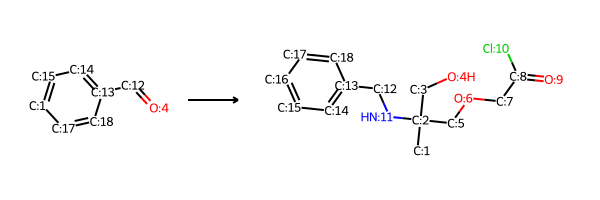

After processed:


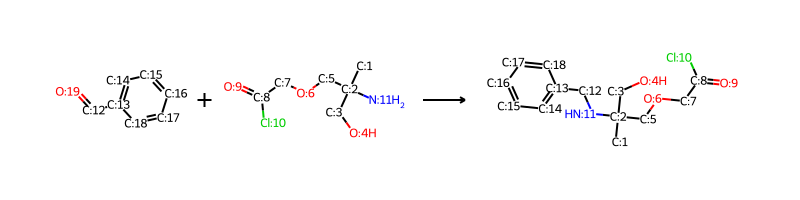

In [2]:
rxn_type = "ReductiveAmination"
rxn_id = 33800230
original_rxn = "[cH:1]1[cH:15][cH:14][c:13]([CH:12]=[O:4])[cH:18][cH:17]1>>[CH3:1][C:2]([CH2:3][OH:4])([CH2:5][O:6][CH2:7][C:8](=[O:9])[Cl:10])[NH:11][CH2:12][c:13]1[cH:14][cH:15][cH:16][cH:17][cH:18]1"
rxn_1 = Reactions.ReactionFromSmarts(original_rxn, useSmiles=True)
correct_rxn = "[CH:12]([c:13]1[cH:14][cH:15][cH:16][cH:17][cH:18]1)=[O:19].[CH3:1][C:2]([CH2:3][OH:4])([CH2:5][O:6][CH2:7][C:8](=[O:9])[Cl:10])[NH2:11]>>[CH3:1][C:2]([CH2:3][OH:4])([CH2:5][O:6][CH2:7][C:8](=[O:9])[Cl:10])[NH:11][CH2:12][c:13]1[cH:14][cH:15][cH:16][cH:17][cH:18]1"
rxn_2 = Reactions.ReactionFromSmarts(correct_rxn, useSmiles=True)

print("original reaction type: {}, reaction id: {}".format(rxn_type, rxn_id))
display(Draw.ReactionToImage(rxn_1))
print("After processed:")
display(Draw.ReactionToImage(rxn_2))

### (2) Somehow new atoms in the product site

original reaction type: DielsAlder, reaction id: 30743792


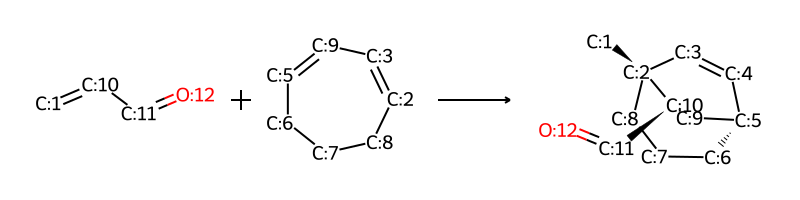

--- This reaction should be discarded because of the unmatched C:1 atom in the product site. ---


In [3]:
rxn_type = "DielsAlder"
rxn_id = 30743792
original_rxn = "[CH2:1]=[CH:10][CH:11]=[O:12].[CH:2]1=[CH:3][CH:9]=[CH:5][CH2:6][CH2:7][CH2:8]1>>[CH3:1][C@:2]12[CH:3]=[CH:4][C@H:5]([CH2:6][CH2:7][CH2:8]1)[CH2:9][C@H:10]2[CH:11]=[O:12]"
rxn_1 = Reactions.ReactionFromSmarts(original_rxn, useSmiles=True)

print("original reaction type: {}, reaction id: {}".format(rxn_type, rxn_id))
display(Draw.ReactionToImage(rxn_1))
print("--- This reaction should be discarded because of the unmatched C:1 atom in the product site. ---")

original reaction type: Friedel-CraftsAcylation, reaction id: 40781365


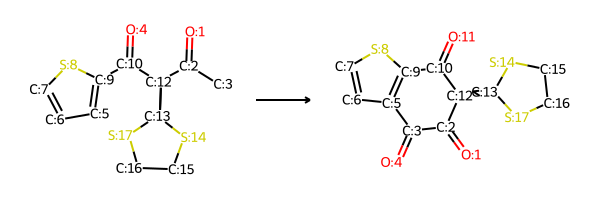

--- This reaction should be discarded because of the unmatched O:4 atom in the product site. ---


In [4]:
rxn_type = "Friedel-CraftsAcylation"
rxn_id = 40781365
original_rxn = "[O:1]=[C:2]([CH3:3])[C:12]([C:10](=[O:4])[c:9]1[cH:5][cH:6][cH:7][s:8]1)=[C:13]1[S:14][CH2:15][CH2:16][S:17]1>>[O:1]=[C:2]1[C:3](=[O:4])[c:5]2[cH:6][cH:7][s:8][c:9]2[C:10](=[O:11])[C:12]1=[C:13]1[S:14][CH2:15][CH2:16][S:17]1"
rxn_1 = Reactions.ReactionFromSmarts(original_rxn, useSmiles=True)

print("original reaction type: {}, reaction id: {}".format(rxn_type, rxn_id))
display(Draw.ReactionToImage(rxn_1))
print("--- This reaction should be discarded because of the unmatched O:4 atom in the product site. ---")

### (3) The uncommon reaction not belonging to its reaction type (with too less templates)

original reaction type: DielsAlder, reaction id: 9021436


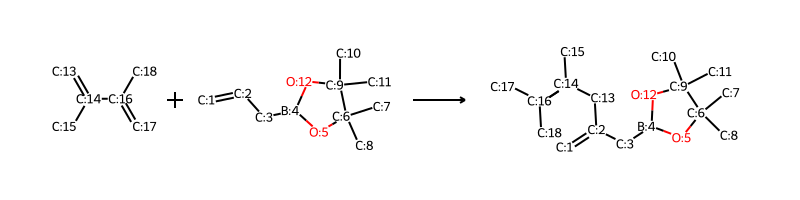

--- This reaction should be discarded because of its too rare reaction template. ---


In [5]:
rxn_type = "DielsAlder"
rxn_id = 9021436
original_rxn = "[CH2:13]=[C:14]([CH3:15])[C:16](=[CH2:17])[CH3:18].[CH2:1]=[CH:2][CH2:3][B:4]1[O:5][C:6]([CH3:7])([CH3:8])[C:9]([CH3:10])([CH3:11])[O:12]1>>[CH2:1]=[C:2]([CH2:3][B:4]1[O:5][C:6]([CH3:7])([CH3:8])[C:9]([CH3:10])([CH3:11])[O:12]1)[CH2:13][C:14]([CH3:15])=[C:16]([CH3:17])[CH3:18]"
rxn_1 = Reactions.ReactionFromSmarts(original_rxn, useSmiles=True)

print("original reaction type: {}, reaction id: {}".format(rxn_type, rxn_id))
display(Draw.ReactionToImage(rxn_1))
print("--- This reaction should be discarded because of its too rare reaction template. ---")

### (4) Wrong reaction records (cannot be recovered by any other reaction template in the records)

original reaction type: PausonKhandReaction, reaction id: 44882622


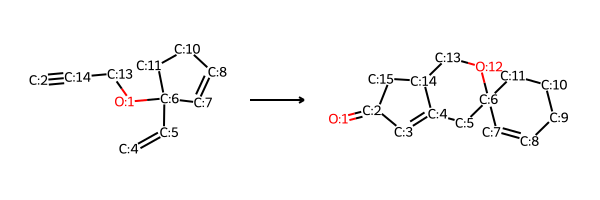

--- This reaction should be discarded because of the wrong manual recording. ---
In the reference, https://www.tandfonline.com/doi/full/10.1080/00397911.2016.1274032
The expected reactant of this reaction should be:
[CH:3]#[C:4][CH2:5][C:6]1([O:12][CH2:13][C:14])[CH:7]=[CH:8][CH2:9][CH2:10][CH2:11]1.[O:1]=[C:2]=[CH2:15]>>[O:1]=[C:2]1[CH:3]=[C:4]2[CH2:5][C:6]3([CH:7]=[CH:8][CH2:9][CH2:10][CH2:11]3)[O:12][CH2:13][CH:14]2[CH2:15]1
4-14-1.0;2-15-1.0;3-4-2.0;2-3-1.0;14-15-1.0


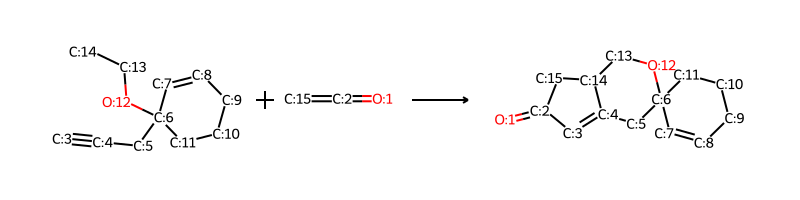

In [6]:
rxn_type = "PausonKhandReaction"
rxn_id = 44882622
original_rxn = "[O:1]([C:6]1([CH:5]=[CH2:4])[CH:7]=[CH:8][CH2:10][CH2:11]1)[CH2:13][C:14]#[CH:2]>>[O:1]=[C:2]1[CH:3]=[C:4]2[CH2:5][C:6]3([CH:7]=[CH:8][CH2:9][CH2:10][CH2:11]3)[O:12][CH2:13][CH:14]2[CH2:15]1"
rxn_1 = Reactions.ReactionFromSmarts(original_rxn, useSmiles=True)

print("original reaction type: {}, reaction id: {}".format(rxn_type, rxn_id))
display(Draw.ReactionToImage(rxn_1))
print("--- This reaction should be discarded because of the wrong manual recording. ---")

print("In the reference, https://www.tandfonline.com/doi/full/10.1080/00397911.2016.1274032")
print("The expected reactant of this reaction should be:")

template = "[#6:4]1-[#6:5]-[#6:1]-[#6:2]=[#6:3]-1>>[#6;H0:1].[#6:2]#[#6:3].[#6:4]=[#6:5]"
product = original_rxn.split('>>')[1]
correct_rxn = rdchiralRunText_modified(template, product)[0] + '>>' + product
print(correct_rxn)
print(GetAnswer(correct_rxn))
rxn_2 = Reactions.ReactionFromSmarts(correct_rxn, useSmiles=True)
display(Draw.ReactionToImage(rxn_2))

# 2. Template extraction procedure and illustration
#### It should be noted that the atom charge and radical site cannot be visualized using RDkit package.

### (1) An simple normal case illustration

original reaction type: GrignardReaction, reaction id: 10279043


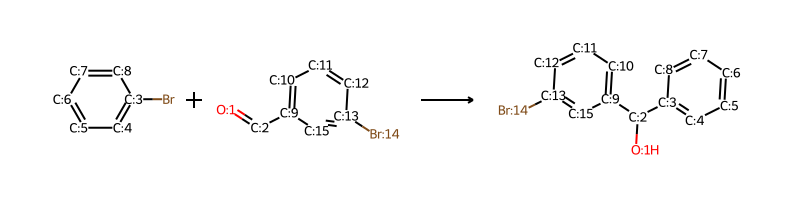

The extracted rdchiral template is:
[OH;D1;+0:4]-[CH;D3;+0:5](-[c:6])-[c;H0;D3;+0:1](:[c:2]):[c:3]>>Br-[c;H0;D3;+0:1](:[c:2]):[c:3].[O;H0;D1;+0:4]=[CH;D2;+0:5]-[c:6]
The extracted universal template is:
[#6:1]-[#6:2]-[#8:3]>>Br-[#6:1].[#6:2]=[#8:3]


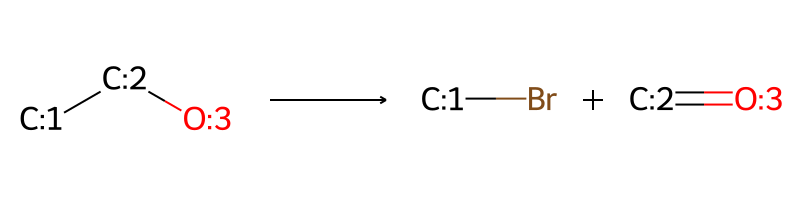

In [7]:
rxn_type = "GrignardReaction"
rxn_id = 10279043
original_rxn = "Br[c:3]1[cH:4][cH:5][cH:6][cH:7][cH:8]1.[O:1]=[CH:2][c:9]1[cH:10][cH:11][cH:12][c:13]([Br:14])[cH:15]1>>[OH:1][CH:2]([c:3]1[cH:4][cH:5][cH:6][cH:7][cH:8]1)[c:9]1[cH:10][cH:11][cH:12][c:13]([Br:14])[cH:15]1"
rxn_1 = Reactions.ReactionFromSmarts(original_rxn, useSmiles=True)

print("original reaction type: {}, reaction id: {}".format(rxn_type, rxn_id))
display(Draw.ReactionToImage(rxn_1))

reaction = {"_id": rxn_id, "reactants":original_rxn.split(">>")[0], "products":original_rxn.split(">>")[1]}
rdchiral_template = rdchiral_extract_rxn(reaction)["reaction_smarts"]
print("The extracted rdchiral template is:")
print(rdchiral_template)


print("The extracted universal template is:")
template = extract_from_rxn_smiles(original_rxn)
rxn_smarts = Reactions.ReactionFromSmarts(template, useSmiles=False)
print(template)
display(Draw.ReactionToImage(rxn_smarts))

### (2) Include the charge if the charge of atom is changed

original reaction type: Huisgen cycloaddition, reaction id: 29604814
6-7-1.5;8-16-1.5;16-17-1.5;6-17-1.5;7-8-1.5


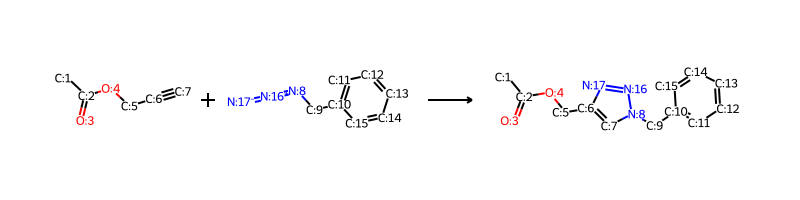

[#6:1]1:[#6:2]:[#7:3]:[#7:4]:[#7:5]:1>>[#6:1]#[#6:2].[#7:3]=[#7;+1:4]=[#7;-1:5]


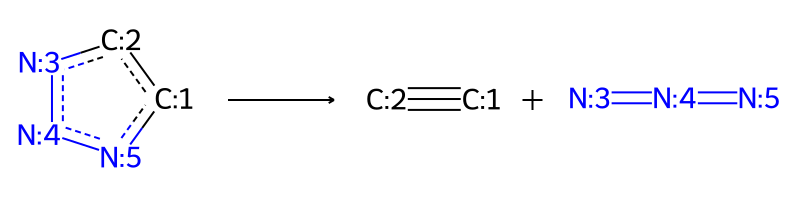

In [4]:
rxn_type = "Huisgen cycloaddition"
rxn_id = 29604814
original_rxn = "[CH3:1][C:2](=[O:3])[O:4][CH2:5][C:6]#[CH:7].[N:8]([CH2:9][c:10]1[cH:11][cH:12][cH:13][cH:14][cH:15]1)=[N+:16]=[N-:17]>>[CH3:1][C:2](=[O:3])[O:4][CH2:5][c:6]1[cH:7][n:8]([CH2:9][c:10]2[cH:11][cH:12][cH:13][cH:14][cH:15]2)[n:16][n:17]1"
rxn_1 = Reactions.ReactionFromSmarts(original_rxn, useSmiles=True)

print("original reaction type: {}, reaction id: {}".format(rxn_type, rxn_id))
print(GetAnswer(original_rxn))
display(Draw.ReactionToImage(rxn_1))

template = extract_from_rxn_smiles(original_rxn)
rxn_smarts = Reactions.ReactionFromSmarts(template, useSmiles=False)
print(template)
display(Draw.ReactionToImage(rxn_smarts))

### (3)	Include the number of hydrogen if the atoms violate the octet rule

original reaction type: Friedel-CraftsAlkylation, reaction id: 29638126
11-12-1.0


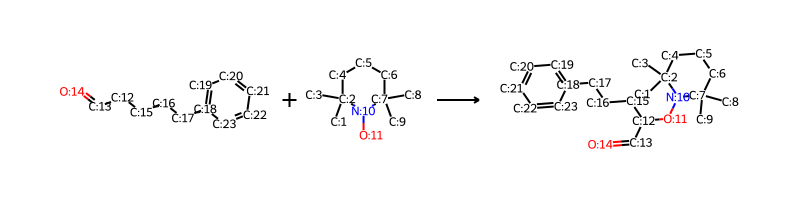

[#6:1]-[#8:2]>>[#6:1].[#8;H0:2]


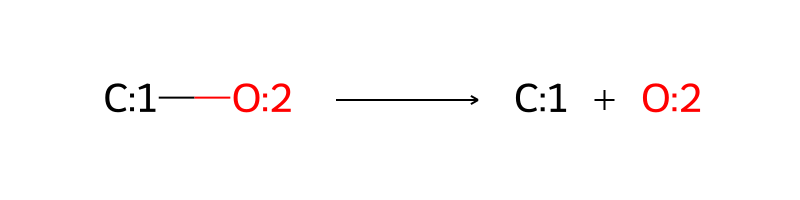

In [2]:
rxn_type = "Friedel-CraftsAlkylation"
rxn_id = 29638126
original_rxn = "[CH2:12]([CH:13]=[O:14])[CH2:15][CH2:16][CH2:17][c:18]1[cH:19][cH:20][cH:21][cH:22][cH:23]1.[CH3:1][C:2]1([CH3:3])[CH2:4][CH2:5][CH2:6][C:7]([CH3:8])([CH3:9])[N:10]1[O:11]>>[CH3:1][C:2]1([CH3:3])[CH2:4][CH2:5][CH2:6][C:7]([CH3:8])([CH3:9])[N:10]1[O:11][CH:12]([CH:13]=[O:14])[CH2:15][CH2:16][CH2:17][c:18]1[cH:19][cH:20][cH:21][cH:22][cH:23]1"
rxn_1 = Reactions.ReactionFromSmarts(original_rxn, useSmiles=True)

print("original reaction type: {}, reaction id: {}".format(rxn_type, rxn_id))
print(GetAnswer(original_rxn))
display(Draw.ReactionToImage(rxn_1))

template = extract_from_rxn_smiles(original_rxn)
rxn_smarts = Reactions.ReactionFromSmarts(template, useSmiles=False)
print(template)
display(Draw.ReactionToImage(rxn_smarts))

### (4)	Include the path atoms between the separate reaction center

original reaction type: FischerIndoleSynthesis, reaction id: 35784196


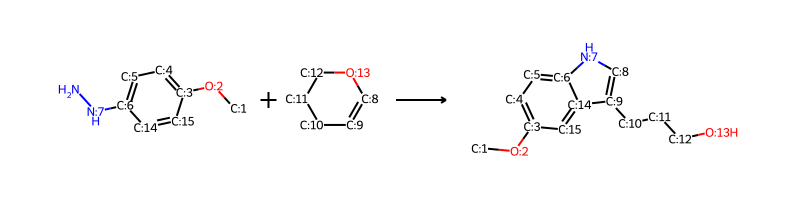

[#8:7]-[#6:6]-[#6:5]-[#6:4]-[#6:9]1:[#6:3]:[#6:2]:[#7:1]:[#6:8]:1>>N-[#7:1]-[#6:2]:[#6:3].[#6:4]1-[#6:5]-[#6:6]-[#8:7]-[#6:8]=[#6:9]-1


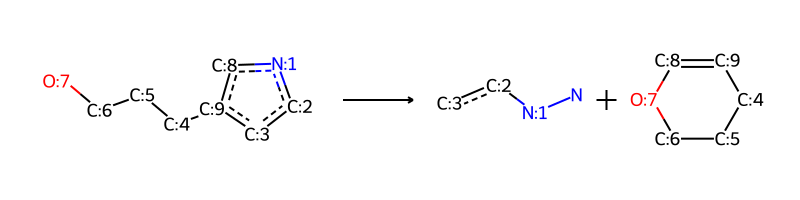

In [10]:
rxn_type = "FischerIndoleSynthesis"
rxn_id = 35784196
original_rxn = "N[NH:7][c:6]1[cH:5][cH:4][c:3]([O:2][CH3:1])[cH:15][cH:14]1.[CH:8]1=[CH:9][CH2:10][CH2:11][CH2:12][O:13]1>>[CH3:1][O:2][c:3]1[cH:4][cH:5][c:6]2[nH:7][cH:8][c:9]([CH2:10][CH2:11][CH2:12][OH:13])[c:14]2[cH:15]1"
rxn_1 = Reactions.ReactionFromSmarts(original_rxn, useSmiles=True)

print("original reaction type: {}, reaction id: {}".format(rxn_type, rxn_id))
display(Draw.ReactionToImage(rxn_1))

template = extract_from_rxn_smiles(original_rxn)
rxn_smarts = Reactions.ReactionFromSmarts(template, useSmiles=False)
print(template)
display(Draw.ReactionToImage(rxn_smarts))

# 3. Template canonicalization (to reduce the redudant templates)
### (1) Merge the same reaction template (use graph isomorphism to check the reactant and porduct pairs)

In [11]:
pass

### (2) Merge the reaction template with more "bond change number" into the reaction template with less "bond change number".

The first template has BCN = 7
[#16:1]1-[#6:3]-[#6:4]=[#6:6]-[#6:5]-[#7:2]-1>>[#16:1]=[#7:2].[#6:3]=[#6:4]-[#6:5]=[#6:6]
answer: 2-5-0.0;1-2-2.0;3-4-2.0;5-6-2.0;4-6-0.0;4-5-1.0;1-3-0.0


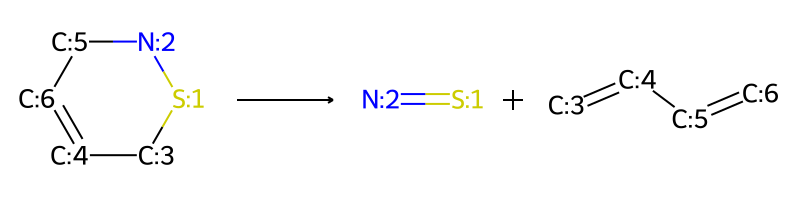

The second template has BCN = 6
[#16:1]1-[#6:6]-[#6:5]=[#6:4]-[#6:3]-[#7:2]-1>>[#16:1]=[#7:2].[#6:3]=[#6:4]-[#6:5]=[#6:6]
answer: 2-3-0.0;1-2-2.0;3-4-2.0;5-6-2.0;1-6-0.0;4-5-1.0


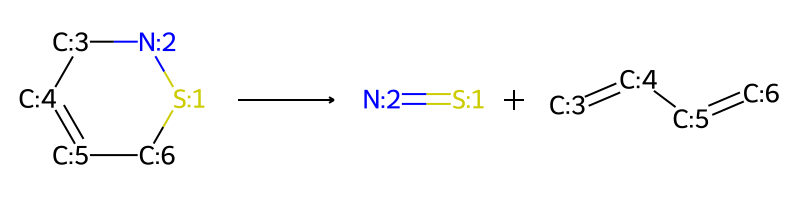

In [12]:
template_1 = "[#16:1]1-[#6:3]-[#6:4]=[#6:6]-[#6:5]-[#7:2]-1>>[#16:1]=[#7:2].[#6:3]=[#6:4]-[#6:5]=[#6:6]"
template_2 = "[#16:1]1-[#6:6]-[#6:5]=[#6:4]-[#6:3]-[#7:2]-1>>[#16:1]=[#7:2].[#6:3]=[#6:4]-[#6:5]=[#6:6]"
rxn_smarts_1 = Reactions.ReactionFromSmarts(template_1, useSmiles=False)
rxn_smarts_2 = Reactions.ReactionFromSmarts(template_2, useSmiles=False)

print("The first template has BCN = {}".format(countBCN(template_1)))
print(template_1)
print("answer:", GetAnswer(template_1))
display(Draw.ReactionToImage(rxn_smarts_1))

print("The second template has BCN = {}".format(countBCN(template_2)))
print(template_2)
print("answer:", GetAnswer(template_2))
display(Draw.ReactionToImage(rxn_smarts_2))